In [ ]:
!wget 'https://raw.githubusercontent.com/YashDRaja/drawing-model-training/main/classes.txt'

--2021-03-16 22:00:58--  https://raw.githubusercontent.com/YashDRaja/drawing-model-training/main/classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383 [text/plain]
Saving to: ‘classes.txt.2’

classes.txt.2       100%[===================>]     383  --.-KB/s    in 0s      

2021-03-16 22:00:58 (31.9 MB/s) - ‘classes.txt.2’ saved [383/383]



In [ ]:
f = open("classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [ ]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
import urllib.request

def download():
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [ ]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/drums.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/laptop.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/anvil.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/baseball%20bat.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/ladder.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eyeglasses.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/grapes.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dumbbell.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/traffic%20light.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/wristwatch.npy
https://storage.googleapis.com/quickdraw_dat

In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf

In [ ]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [ ]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [ ]:
print(len(x_train))

160000


mushroom


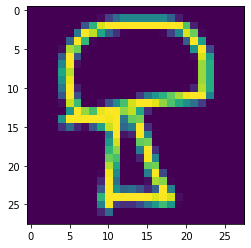

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

In [ ]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics=['top_k_categorical_accuracy', 'accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 576)              

In [ ]:
model.fit(x = x_train, y = y_train, epochs=10, validation_split = 0.1, verbose = 1)

Epoch 1/10
4500/4500 [==============================] - 17s 4ms/step - loss: 1.5440 - top_k_categorical_accuracy: 0.8265 - accuracy: 0.5929 - val_loss: 0.8099 - val_top_k_categorical_accuracy: 0.9413 - val_accuracy: 0.7763
Epoch 2/10
4500/4500 [==============================] - 17s 4ms/step - loss: 0.7032 - top_k_categorical_accuracy: 0.9475 - accuracy: 0.8103 - val_loss: 0.6356 - val_top_k_categorical_accuracy: 0.9538 - val_accuracy: 0.8282
Epoch 3/10
4500/4500 [==============================] - 16s 4ms/step - loss: 0.5743 - top_k_categorical_accuracy: 0.9574 - accuracy: 0.8449 - val_loss: 0.5916 - val_top_k_categorical_accuracy: 0.9565 - val_accuracy: 0.8408
Epoch 4/10
4500/4500 [==============================] - 17s 4ms/step - loss: 0.5025 - top_k_categorical_accuracy: 0.9641 - accuracy: 0.8626 - val_loss: 0.5759 - val_top_k_categorical_accuracy: 0.9595 - val_accuracy: 0.8463
Epoch 5/10
4500/4500 [==============================] - 16s 4ms/step - loss: 0.4469 - top_k_categorical_accu

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 95.13%


eyeglasses
['eyeglasses', 'drums', 'dumbbell', 'cloud', 'face']


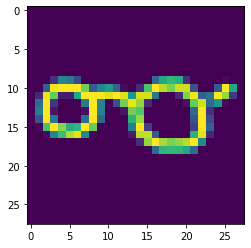

In [ ]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
print(class_names[np.where(y_test[idx] == 1)[0][0]])

plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [ ]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
model.fit(x = x_train, y = y_train, epochs=1, validation_split = 0.1, verbose = 1, callbacks=[cp_callback])

4500/4500 [==============================] - 17s 4ms/step - loss: 0.2724 - top_k_categorical_accuracy: 0.9862 - accuracy: 0.9175 - val_loss: 0.6941 - val_top_k_categorical_accuracy: 0.9534 - val_accuracy: 0.8429

Epoch 00001: saving model to training_1/cp.ckpt


In [ ]:
ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 112kB 10.6MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
model.save('keras.h5')

In [ ]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2021-03-16 23:02:12.679581: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
!cp class_names.txt model/class_names.txt

In [ ]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 7%)
  adding: model/model.json (deflated 82%)
  adding: model/class_names.txt (deflated 39%)


In [ ]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>